In [ ]:
# ===========================
# Cell 1: Imports
# ===========================
import os
import shutil
import random

import numpy as np
from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

print("TensorFlow:", tf.__version__)


TensorFlow: 2.19.0


In [ ]:
# ===== CAMERA → SHELTER MAPPING =====

RAW_CAMERA_TO_SHELTER = {
    "mu entrance 5": "Memorial Union",
    "hayden_lib": "Hayden Library",
    "coor_hall": "Coor Hall Lobby",
    "student_pavilion": "Memorial Union",
    "tempe_transport": "ASU Transit Center",
    "asu_camera": "Nearest indoor building",
    "generic_clear_area": "Nearest indoor building",
}

# Normalize keys
CAMERA_TO_SHELTER = {
    k.lower().replace(" ", "_"): v for k, v in RAW_CAMERA_TO_SHELTER.items()
}


In [ ]:
# ===========================
# Cell 2: Unzip dataset
# ===========================
!unzip -o "Final_dataset 3.zip" -d .

print("Root contents after unzip:")
!ls


Archive:  Final_dataset 3.zip
   creating: ./Final_dataset 3/
   creating: ./Final_dataset 3/dust/
  inflating: ./__MACOSX/Final_dataset 3/._dust  
  inflating: ./Final_dataset 3/.DS_Store  
  inflating: ./__MACOSX/Final_dataset 3/._.DS_Store  
   creating: ./Final_dataset 3/asu_dust/
  inflating: ./__MACOSX/Final_dataset 3/._asu_dust  
   creating: ./Final_dataset 3/clear/
  inflating: ./Final_dataset 3/dust/63.jpg  
  inflating: ./__MACOSX/Final_dataset 3/dust/._63.jpg  
  inflating: ./Final_dataset 3/dust/77.jpg  
  inflating: ./__MACOSX/Final_dataset 3/dust/._77.jpg  
  inflating: ./Final_dataset 3/dust/76.jpg  
  inflating: ./__MACOSX/Final_dataset 3/dust/._76.jpg  
  inflating: ./Final_dataset 3/dust/62.jpg  
  inflating: ./__MACOSX/Final_dataset 3/dust/._62.jpg  
  inflating: ./Final_dataset 3/dust/74.jpg  
  inflating: ./__MACOSX/Final_dataset 3/dust/._74.jpg  
  inflating: ./Final_dataset 3/dust/60.jpg  
  inflating: ./__MACOSX/Final_dataset 3/dust/._60.jpg  
  inflating: ./Fi

In [ ]:
# ===========================
# Cell 3: Paths & Parameters
# ===========================

# Use the folder you actually have after unzip:
DATASET_ROOT    = "Final_dataset 3"   # <--- this is what you see in the sidebar
CLEAR_SUBFOLDER = "clear"
DUST_SUBFOLDER  = "dust"

GENERIC_CLEAR_DIR = os.path.join(DATASET_ROOT, CLEAR_SUBFOLDER)
GENERIC_DUST_DIR  = os.path.join(DATASET_ROOT, DUST_SUBFOLDER)

# ASU dust images are also inside Final_dataset 3/asu_dust
ASU_DUST_DIR = os.path.join(DATASET_ROOT, "asu_dust")

FINAL_DATASET_ROOT = "final_dataset"
FINAL_CLEAR_DIR = os.path.join(FINAL_DATASET_ROOT, "clear")
FINAL_DUST_DIR  = os.path.join(FINAL_DATASET_ROOT, "dust")

IMG_HEIGHT = 128
IMG_WIDTH  = 128
BATCH_SIZE = 16
RANDOM_SEED = 42

image_extensions = (".jpg", ".jpeg", ".png", ".bmp")

print("GENERIC_CLEAR_DIR:", GENERIC_CLEAR_DIR)
print("GENERIC_DUST_DIR :", GENERIC_DUST_DIR)
print("ASU_DUST_DIR     :", ASU_DUST_DIR)



GENERIC_CLEAR_DIR: Final_dataset 3/clear
GENERIC_DUST_DIR : Final_dataset 3/dust
ASU_DUST_DIR     : Final_dataset 3/asu_dust


In [ ]:
# ===========================
# Helper: recursively list image files inside subfolders
# ===========================
import os

def list_image_files(root_dir, exts=(".jpg", ".jpeg", ".png", ".bmp")):
    """Return a list of image file paths under root_dir (including subfolders)."""
    image_paths = []
    for cur_root, dirs, files in os.walk(root_dir):
        for f in files:
            if f.lower().endswith(exts):
                image_paths.append(os.path.join(cur_root, f))
    return image_paths


In [ ]:
print("Clear images:", len(os.listdir(GENERIC_CLEAR_DIR)))
print("Dust images :", len(os.listdir(GENERIC_DUST_DIR)))
if os.path.exists(ASU_DUST_DIR):
    print("ASU dust images:", len(os.listdir(ASU_DUST_DIR)))
else:
    print("ASU dust folder not found yet.")


Clear images: 51
Dust images : 81
ASU dust images: 10


In [ ]:
# ===========================
# Cell 4: Synthetic dust generator
# ===========================

def add_synthetic_dust(pil_img):
    """
    Takes a PIL image and returns a new PIL image with synthetic dust effect.
    """
    img = pil_img.convert("RGB").resize((IMG_WIDTH, IMG_HEIGHT))
    img_np = np.array(img).astype(np.float32) / 255.0

    # 1) Add light brown haze (dust in the air)
    haze_color = np.array([0.75, 0.65, 0.50])  # light brown
    alpha = 0.35
    img_hazy = (1 - alpha) * img_np + alpha * haze_color

    # 2) Add random noise (dust particles)
    noise = np.random.normal(loc=0.0, scale=0.08, size=img_hazy.shape)
    img_noisy = np.clip(img_hazy + noise, 0.0, 1.0)

    # 3) Convert back to PIL, blur slightly, reduce contrast & sharpness
    img_noisy_uint8 = (img_noisy * 255).astype(np.uint8)
    dusty_img = Image.fromarray(img_noisy_uint8)

    dusty_img = dusty_img.filter(ImageFilter.GaussianBlur(radius=1.0))
    dusty_img = ImageEnhance.Contrast(dusty_img).enhance(0.8)
    dusty_img = ImageEnhance.Sharpness(dusty_img).enhance(0.8)

    return dusty_img


In [ ]:
# ===========================
# Cell 5 (FIXED): Augment ASU dust images (with subfolders)
# ===========================

if not os.path.exists(ASU_DUST_DIR):
    print("⚠️ ASU_DUST_DIR not found. Skipping ASU dust augmentation.")
else:
    asu_dust_image_paths = list_image_files(ASU_DUST_DIR, image_extensions)
    print(f"Found {len(asu_dust_image_paths)} original ASU dust images under {ASU_DUST_DIR}")

    for src_path in asu_dust_image_paths:
        root, filename = os.path.split(src_path)
        name, ext = os.path.splitext(filename)
        dst_path = os.path.join(root, f"{name}_synthetic{ext}")

        # avoid recreating if already exists
        if os.path.exists(dst_path):
            continue

        try:
            img = Image.open(src_path)
            dusty_img = add_synthetic_dust(img)
            dusty_img.save(dst_path)
        except Exception as e:
            print("Error processing", src_path, ":", e)

    print(" Synthetic dust images ADDED under:", ASU_DUST_DIR)
    print("Total image files now in ASU_DUST_DIR (including synthetic):",
          len(list_image_files(ASU_DUST_DIR, image_extensions)))


Found 100 original ASU dust images under Final_dataset 3/asu_dust
 Synthetic dust images ADDED under: Final_dataset 3/asu_dust
Total image files now in ASU_DUST_DIR (including synthetic): 150


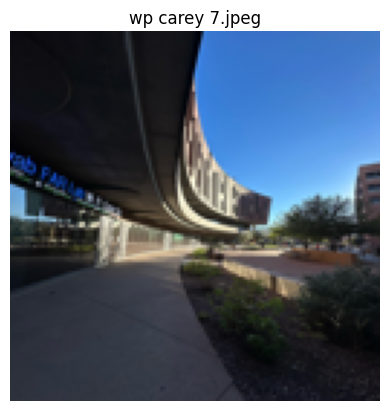

In [ ]:
# OPTIONAL visual check (FIXED)
if os.path.exists(ASU_DUST_DIR):
    all_asu_dust_imgs = list_image_files(ASU_DUST_DIR, image_extensions)
    if len(all_asu_dust_imgs) > 0:
        sample_path = random.choice(all_asu_dust_imgs)
        img = Image.open(sample_path).resize((IMG_WIDTH, IMG_HEIGHT))
        plt.imshow(img)
        plt.axis("off")
        plt.title(os.path.basename(sample_path))
        plt.show()
    else:
        print("No ASU dust images found inside subfolders.")


In [ ]:
# ===========================
# Cell 6: Build final_dataset for training
# ===========================

# Start fresh
if os.path.exists(FINAL_DATASET_ROOT):
    shutil.rmtree(FINAL_DATASET_ROOT)

os.makedirs(FINAL_CLEAR_DIR, exist_ok=True)
os.makedirs(FINAL_DUST_DIR, exist_ok=True)

# Copy CLEAR images
clear_paths = list_image_files(GENERIC_CLEAR_DIR, image_extensions)
for src in clear_paths:
    filename = os.path.basename(src)
    dst = os.path.join(FINAL_CLEAR_DIR, filename)
    shutil.copy2(src, dst)

# Copy GENERIC DUST images
dust_paths = list_image_files(GENERIC_DUST_DIR, image_extensions)
for src in dust_paths:
    filename = os.path.basename(src)
    dst = os.path.join(FINAL_DUST_DIR, filename)
    shutil.copy2(src, dst)

# Copy ASU DUST images (original + synthetic)
asu_paths = list_image_files(ASU_DUST_DIR, image_extensions)
for src in asu_paths:
    filename = "asu_" + os.path.basename(src)
    dst = os.path.join(FINAL_DUST_DIR, filename)
    shutil.copy2(src, dst)

print("Final dataset created ✔")
print("CLEAR images:", len(os.listdir(FINAL_CLEAR_DIR)))
print("DUST images :", len(os.listdir(FINAL_DUST_DIR)))


Final dataset created ✔
CLEAR images: 50
DUST images : 230


In [ ]:
# ===========================
# Cell 7: Data Generators
# ===========================
tf.random.set_seed(RANDOM_SEED)

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    FINAL_DATASET_ROOT,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    FINAL_DATASET_ROOT,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

print("Class indices:", train_gen.class_indices)


Found 224 images belonging to 2 classes.
Found 56 images belonging to 2 classes.
Class indices: {'clear': 0, 'dust': 1}


In [ ]:
# ===========================
# Cell 8: Class Weights
# ===========================
num_clear = len(os.listdir(FINAL_CLEAR_DIR))
num_dust  = len(os.listdir(FINAL_DUST_DIR))
total = num_clear + num_dust

idx_clear = train_gen.class_indices['clear']
idx_dust = train_gen.class_indices['dust']

class_weight = {
    idx_clear: total / (2 * num_clear),
    idx_dust: total / (2 * num_dust)
}

print("Class weight:", class_weight)


Class weight: {0: 2.8, 1: 0.6086956521739131}


In [ ]:
# ===========================
# Cell 9: Model Build
# ===========================
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# ===========================
# Cell 10: Train model
# ===========================

EPOCHS = 20
checkpoint_path = "best_dustguard_model.keras"

callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True)
]

history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    class_weight=class_weight,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.2060 - loss: 0.8371 - precision: 0.4977 - recall: 0.0863 - val_accuracy: 0.1786 - val_loss: 0.7660 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.2858 - loss: 0.6975 - precision: 0.7846 - recall: 0.2377 - val_accuracy: 0.6607 - val_loss: 0.6682 - val_precision: 0.9655 - val_recall: 0.6087
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.4949 - loss: 0.6341 - precision: 0.9106 - recall: 0.4470 - val_accuracy: 0.9107 - val_loss: 0.6139 - val_precision: 1.0000 - val_recall: 0.8913
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.5545 - loss: 0.6241 - precision: 0.8997 - recall: 0.5490 - val_accuracy: 0.9286 - val_loss: 0.5868 - val_precision: 1.0000 - val_recall: 0.9130
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.5436 - loss: 0.6587 - precision: 0.9082 - recall: 0.4953 - val_accuracy: 0.9643 - val_loss: 0.56

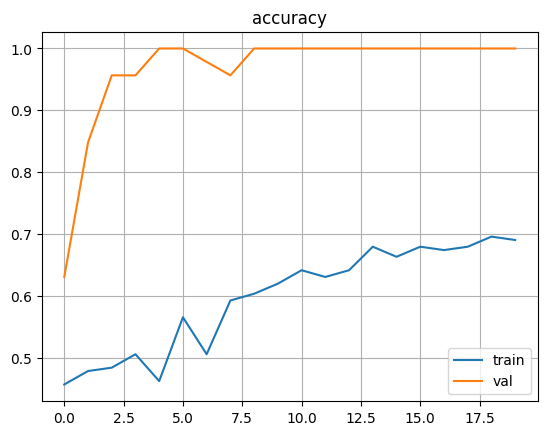

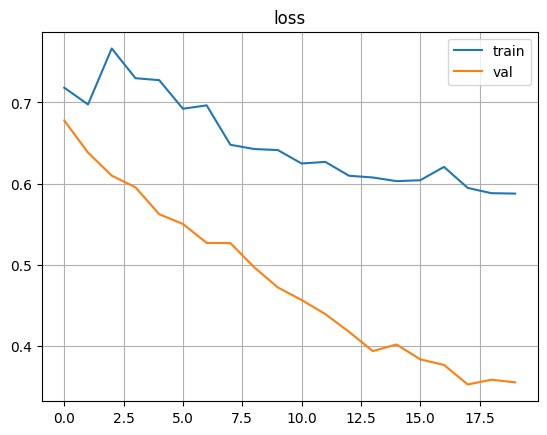

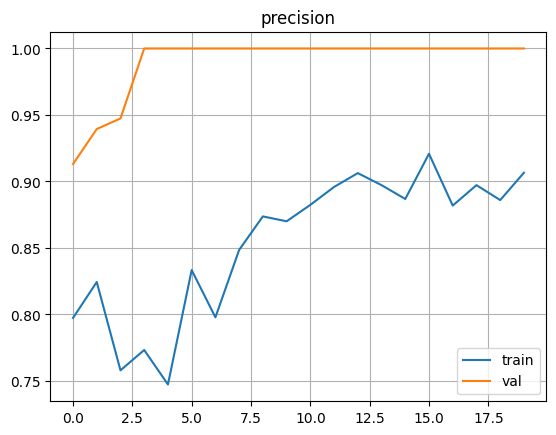

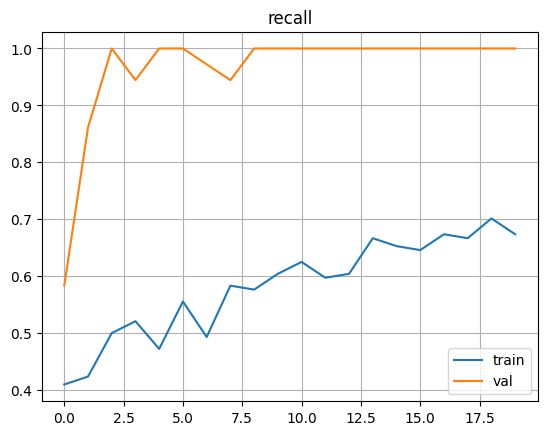

3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 1.0000 - loss: 0.3901 - precision: 1.0000 - recall: 1.0000
ACC: 1.000, PREC: 1.000, REC: 1.000


In [ ]:
# ===========================
# Cell 11: Plots & Evaluation
# ===========================

def plot_metric(history, metric):
    plt.figure()
    plt.plot(history.history[metric], label="train")
    plt.plot(history.history[f"val_{metric}"], label="val")
    plt.title(metric)
    plt.legend()
    plt.grid()
    plt.show()

plot_metric(history, "accuracy")
plot_metric(history, "loss")
plot_metric(history, "precision")
plot_metric(history, "recall")

val_loss, val_acc, val_prec, val_rec = model.evaluate(val_gen)
print(f"ACC: {val_acc:.3f}, PREC: {val_prec:.3f}, REC: {val_rec:.3f}")

In [ ]:
# ===========================
# Cell 12: Save model
# ===========================
model.save("dustguard_asu_model.keras")
print("Model saved ✔")


Model saved ✔


TIME FOR PREDICTION

In [ ]:
# Cell 1: Load trained model for prediction
import tensorflow as tf

model = tf.keras.models.load_model("best_dustguard_model.keras")
print("Model loaded!")


Model loaded!


In [ ]:
# Cell 2: Prediction + routing functions

from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# index → label mapping from our generators
IDX_TO_LABEL = {v: k for k, v in train_gen.class_indices.items()}
print("Index to label:", IDX_TO_LABEL)

def predict_dust_or_clear(model, img_path, threshold=0.5):
    """
    Use this for ANY image path.
    Returns: label ('dust' or 'clear'), dust_probability
    """
    img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    x = img_to_array(img) / 255.0
    x = np.expand_dims(x, axis=0)

    prob_class1 = model.predict(x)[0][0]  # sigmoid → prob of class 1
    label_for_1 = IDX_TO_LABEL[1]         # which class is index 1?

    # convert to "dust probability"
    if label_for_1 == "dust":
        dust_prob = prob_class1
    else:
        dust_prob = 1 - prob_class1

    label = "dust" if dust_prob >= threshold else "clear"
    return label, float(dust_prob)


# routing map
CAMERA_TO_SHELTER = {
    "cam_library": "Hayden Library",
    "cam_mu": "Memorial Union",
    "cam_stadium": "Sun Devil Stadium",
    "cam_station": "ASU Transit Center"
}

def dustguard_decision(model, img_path, camera_id="generic_clear_area"):
    label, dust_prob = predict_dust_or_clear(model, img_path)

    # normalize camera ID
    norm_cam = camera_id.lower().replace(" ", "_")
    shelter = CAMERA_TO_SHELTER.get(norm_cam, "Nearest indoor building")

    if label == "clear":
        status = "CLEAR"
        message = f"Prediction: CLEAR (dust probability = {dust_prob:.2f}). Movement is safe."
        shelter = None
    else:
        status = "DUST ALERT"
        message = f"Prediction: DUST (dust probability = {dust_prob:.2f}). Route to: {shelter}."

    return status, message, shelter


Index to label: {0: 'clear', 1: 'dust'}


In [ ]:
# ==== NEW Grad-CAM function (safe version for our Sequential model) ====
def get_gradcam_heatmap(img_array, model):
    """
    img_array: shape (1, H, W, 3), already scaled 0-1
    returns: heatmap (H, W) in [0,1]
    """

    # 1. Get the VGG16 part (backbone) from our Sequential model
    backbone = model.layers[0]  # VGG16 base
    last_conv_layer = backbone.get_layer("block5_conv3")

    # 2. Rebuild a small model:
    #    input  -> backbone -> our classifier head (same as original model)
    x = backbone.output
    for layer in model.layers[1:]:
        x = layer(x)
    full_output = x

    grad_model = tf.keras.models.Model(
        inputs=backbone.input,
        outputs=[last_conv_layer.output, full_output]
    )

    # 3. Forward pass + gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)  # (1,Hc,Wc,C), (1,1)
        loss = predictions[:, 0]                           # scalar score

    grads = tape.gradient(loss, conv_outputs)[0]      # (Hc,Wc,C)
    conv_outputs = conv_outputs[0]                    # (Hc,Wc,C)

    # 4. Channel-wise weights (average gradient per channel)
    weights = tf.reduce_mean(grads, axis=(0, 1))      # (C,)

    # 5. Weighted sum of feature maps
    cam = tf.zeros(conv_outputs.shape[0:2], dtype=tf.float32)  # (Hc,Wc)
    for i, w in enumerate(weights):
        cam += w * conv_outputs[:, :, i]

    # 6. ReLU + normalize + resize to image size
    cam = tf.nn.relu(cam)
    cam = cam / (tf.reduce_max(cam) + 1e-8)

    heatmap = tf.image.resize(cam[..., tf.newaxis], (IMG_HEIGHT, IMG_WIDTH))
    heatmap = tf.squeeze(heatmap).numpy()  # (H,W)

    return heatmap


Testing on: Final_dataset 3/clear/mu walkway 7.jpeg
Location (camera_id): mu walkway 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
Status : CLEAR
Message: Prediction: CLEAR (dust probability = 0.48). Movement is safe.
Shelter: None


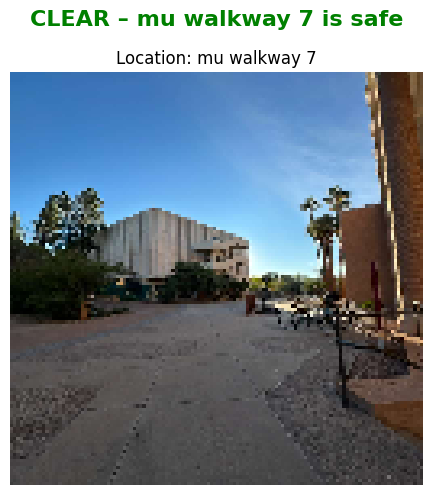

Shelter from dict test: NOT FOUND


In [ ]:
# ===== Cell 3: Real-time DustGuard check on ONE ASU frame =====
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tensorflow.keras.preprocessing.image import load_img, img_to_array

image_extensions = (".jpg", ".jpeg", ".png")

all_images = []

# 1) ASU dust images (real dusty frames)
asu_root = os.path.join("Final_dataset 3", "asu_dust")
for root, dirs, files in os.walk(asu_root):
    for f in files:
        if f.lower().endswith(image_extensions):
            all_images.append(os.path.join(root, f))

#    Clear ASU images
clear_root = os.path.join("Final_dataset 3", "clear")
for f in os.listdir(clear_root):
    if f.lower().endswith(image_extensions):
        all_images.append(os.path.join(clear_root, f))

# Pick ONE random frame
img_path = random.choice(all_images)
print("Testing on:", img_path)

# 2) Infer location / camera_id from path
parts = img_path.split(os.sep)

if "asu_dust" in parts:
    # path looks like .../Final_dataset 3/asu_dust/<location_folder>/image.jpg
    idx = parts.index("asu_dust")
    if idx + 1 < len(parts) - 1:
        location_key = parts[idx + 1]     # e.g. "noble_library"
    else:
        location_key = "asu_camera"
else:
    # for clear images, use filename to build location
    base_name = os.path.splitext(os.path.basename(img_path))[0]
    name_parts = base_name.split("_")
    if len(name_parts) >= 3:
        # e.g. "mu_entrance_5_IMG_1234" -> "mu_entrance_5"
        location_key = "_".join(name_parts[:3])
    else:
        location_key = name_parts[0]

# location_key is used for routing lookup, title uses pretty version
location_title = location_key.replace("_", " ")
camera_id = location_key

print("Location (camera_id):", camera_id)

# 3) Load image
img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
img_arr = img_to_array(img) / 255.0
img_batch = np.expand_dims(img_arr, axis=0)

# 4) Get prediction + routing
status, message, shelter = dustguard_decision(model, img_path, camera_id=camera_id)
print("Status :", status)
print("Message:", message)
print("Shelter:", shelter)

# 5) Plot ONE image, add red box only if DUST ALERT
plt.figure(figsize=(7, 5))
ax = plt.gca()
ax.imshow(img_arr)
ax.axis("off")
ax.set_title(f"Location: {location_title}")

if status == "DUST ALERT":
    # compute heatmap and draw red box on dusty region
    heatmap = get_gradcam_heatmap(img_batch, model)
    threshold = 0.6
    ys, xs = np.where(heatmap >= threshold)

    if len(xs) > 0:
        x_min, x_max = xs.min(), xs.max()
        y_min, y_max = ys.min(), ys.max()
        rect = patches.Rectangle(
            (x_min, y_min),
            x_max - x_min,
            y_max - y_min,
            linewidth=3,
            edgecolor="red",
            facecolor="none"
        )
        ax.add_patch(rect)

    big_title = f" DUST ALERT – {location_title} unsafe.\nRoute to: {shelter}"
    title_color = "red"
else:
    big_title = f"CLEAR – {location_title} is safe"
    title_color = "green"

plt.suptitle(big_title, color=title_color, fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

print("Shelter from dict test:", CAMERA_TO_SHELTER.get(camera_id, "NOT FOUND"))


Saving WhatsApp Image 2025-12-08 at 14.34.10.jpeg to WhatsApp Image 2025-12-08 at 14.34.10.jpeg
Uploaded file: WhatsApp Image 2025-12-08 at 14.34.10.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step

[ORIGINAL IMAGE]
Status : CLEAR
Detail : Prediction: CLEAR (dust probability = 0.39). Movement is safe.


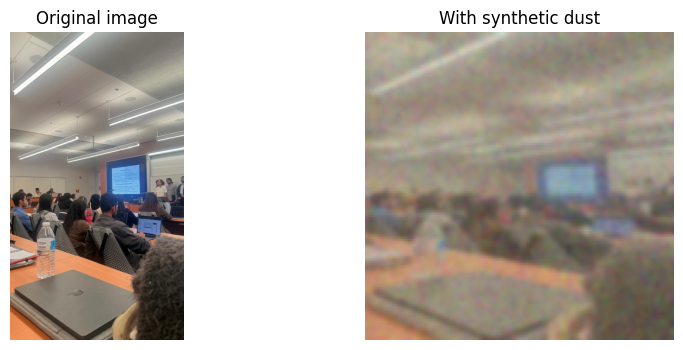

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step

[SYNTHETIC DUST IMAGE]
Status : DUST ALERT
Detail : Prediction: DUST (dust probability = 0.50). Route to: Hayden Library.


In [ ]:
# Cell 4: LIVE DEMO – upload image, add synthetic dust, and predict both

from google.colab import files
import matplotlib.pyplot as plt

uploaded = files.upload()   # choose any image from  laptop

for filename in uploaded.keys():
    img_path = filename
    print("Uploaded file:", img_path)

    # ----- ORIGINAL IMAGE -----
    img = load_img(img_path)
    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("Original image")

    status_orig, msg_orig, _ = dustguard_decision(model, img_path, camera_id="cam_library")
    print("\n[ORIGINAL IMAGE]")
    print("Status :", status_orig)
    print("Detail :", msg_orig)

    # ----- SYNTHETIC DUST VERSION -----
    dusty_pil = add_synthetic_dust(img)          # uses  earlier function
    dusty_path = "synthetic_" + filename
    dusty_pil.save(dusty_path)

    plt.subplot(1,2,2)
    plt.imshow(dusty_pil)
    plt.axis("off")
    plt.title("With synthetic dust")
    plt.show()

    status_syn, msg_syn, _ = dustguard_decision(model, dusty_path, camera_id="cam_library")
    print("\n[SYNTHETIC DUST IMAGE]")
    print("Status :", status_syn)
    print("Detail :", msg_syn)


In [ ]:
# Make sure you are using the FINAL trained model object here
MODEL_EXPORT_NAME = "dustguard_live_model.h5"

model.save(MODEL_EXPORT_NAME, include_optimizer=False)
print("Saved as", MODEL_EXPORT_NAME)


Saved as dustguard_live_model.h5


In [ ]:
# ==== LIVE DEMO SETUP (run once) ====

import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model

IMG_HEIGHT = 128   # <-- change if your model uses a different size
IMG_WIDTH  = 128

DUST_THRESHOLD = 0.52   # probability above which we say "DUST ALERT"

# ==== 1) LOAD YOUR TRAINED MODEL ====
# Make sure this filename matches what you uploaded in the Files pane
MODEL_PATH = "dustguard_asu_model.keras"   # or "best_dustguard_model.keras"

try:
    model = load_model(MODEL_PATH)
    print("✅ Model loaded from:", MODEL_PATH)
except Exception as e:
    print("⚠️ Could not load model from file.")
    print("Error:", e)
    print("If `model` is already in memory from training, we will just use that.")

# ==== 2) CAMERA → SHELTER MAP (routing text) ====
CAMERA_TO_SHELTER = {
    "demo_cam"      : "Nearest indoor building",
    "hayden_lib"    : "Hayden Library basement",
    "mu_entrance_5" : "MU indoor lobby",
    "noble_library" : "Noble Library atrium",
}

def get_shelter(camera_id="demo_cam"):
    return CAMERA_TO_SHELTER.get(camera_id, "Nearest indoor building")

# ==== 3) PREPROCESS FRAME FOR MODEL ====
def preprocess_bgr(frame_bgr):
    """
    Input: OpenCV BGR frame from webcam.
    Output: (1, H, W, 3) float tensor in [0,1]
    """
    frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    resized   = cv2.resize(frame_rgb, (IMG_WIDTH, IMG_HEIGHT))
    x = resized.astype("float32") / 255.0
    return np.expand_dims(x, axis=0), frame_rgb


✅ Model loaded from: dustguard_asu_model.keras


In [ ]:
# ==== PREDICTION ON ONE FRAME ====

def predict_dust_from_frame(frame_bgr, camera_id="demo_cam"):
    x_batch, frame_rgb = preprocess_bgr(frame_bgr)

    # assume model has single sigmoid output
    pred = model.predict(x_batch, verbose=0)[0][0]
    dust_prob = float(pred)

    if dust_prob >= DUST_THRESHOLD:
        label   = "DUST"
        status  = "🚨 DUST ALERT"
        color   = "red"
        shelter = get_shelter(camera_id)
        detail  = f"Prediction: DUST (dust probability = {dust_prob:.2f}). Route to: {shelter}."
    else:
        label   = "CLEAR"
        status  = "✅ CLEAR"
        color   = "green"
        shelter = None
        detail  = f"Prediction: CLEAR (dust probability = {dust_prob:.2f}). Movement is safe."

    # Text log (you can read this out during demo)
    print("Status :", label)
    print("Detail :", detail)
    print("Shelter:", shelter if shelter else "None")

    # Show the webcam frame with a big title
    plt.figure(figsize=(5, 6))
    plt.imshow(frame_rgb)
    plt.axis("off")
    title = f"{status} – {camera_id.replace('_', ' ')}"
    plt.title(title, color=color, fontsize=16, fontweight="bold")
    plt.tight_layout()
    plt.show()


In [ ]:
# ==== CAPTURE ONE FRAME FROM YOUR LAPTOP WEBCAM ====

from IPython.display import Javascript, display
from google.colab import output
from base64 import b64decode

def take_webcam_photo(filename='webcam_frame.jpg', quality=0.8):
    """
    Opens your laptop camera in the browser, shows a 'Capture' button,
    saves one frame to filename, and returns the filename.
    """
    js = Javascript("""
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const video = document.createElement('video');
      const button = document.createElement('button');
      const stopButton = document.createElement('button');

      button.textContent = '📸 Capture frame';
      stopButton.textContent = 'Stop camera';

      div.style.textAlign = 'center';
      document.body.appendChild(div);
      div.appendChild(video);
      div.appendChild(document.createElement('br'));
      div.appendChild(button);
      div.appendChild(stopButton);

      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      video.srcObject = stream;
      await video.play();

      // Capture on button click
      const canvas = document.createElement('canvas');
      const context = canvas.getContext('2d');

      let result = await new Promise((resolve) => {
        button.onclick = () => {
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
          context.drawImage(video, 0, 0);
          stream.getVideoTracks()[0].stop();
          const dataUrl = canvas.toDataURL('image/jpeg', quality);
          div.remove();
          resolve(dataUrl);
        };
        stopButton.onclick = () => {
          stream.getVideoTracks()[0].stop();
          div.remove();
          resolve(null);
        };
      });

      return result;
    }

    (async () => {
      const dataUrl = await takePhoto(%f);
      google.colab.kernel.invokeFunction('notebook.getWebcamImage', [dataUrl], {});
    })();
    """ % quality)

    # Python callback: save image data to file
    def _recv(dataUrl):
        if dataUrl is None:
            print("❌ Camera cancelled.")
            return
        header, encoded = dataUrl.split(',', 1)
        data = b64decode(encoded)
        with open(filename, 'wb') as f:
            f.write(data)
        print("✅ Saved webcam frame to", filename)

    output.register_callback('notebook.getWebcamImage', _recv)
    display(js)
    return filename


<IPython.core.display.Javascript object>

Status : DUST
Detail : Prediction: DUST (dust probability = 0.56). Route to: Nearest indoor building.
Shelter: Nearest indoor building


/tmp/ipython-input-1377358957.py:34: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


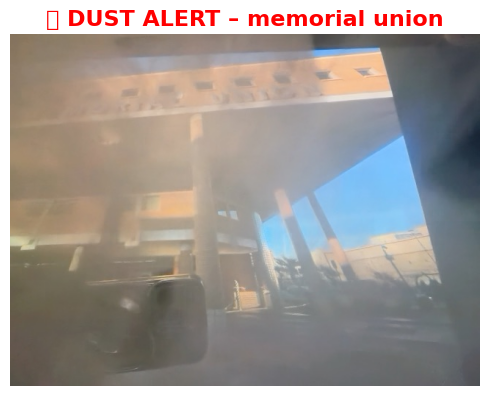

In [66]:
# ==== RUN ONE LIVE DEMO STEP ====

import cv2

# Choose a logical camera/location id – this controls the routing text
camera_id = "memorial_union"   # or "mu_entrance_5", "hayden_lib", etc.

# 1) Capture image from webcam
frame_file = "live_demo_frame.jpg"
take_webcam_photo(frame_file)

# 2) Read it with OpenCV
frame_bgr = cv2.imread(frame_file)
if frame_bgr is None:
    print("⚠️ No frame captured.")
else:
    # 3) Predict and show result
    predict_dust_from_frame(frame_bgr, camera_id=camera_id)
